In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import nibabel as nb
from scipy import stats, signal
import matplotlib.pylab as plt
import seaborn as sns
from nipype.interfaces import ants, fsl

from dipy.viz import regtools

import os

## Prototype map created using:

**MNI ICMB template**:

mni_icbm152_t1_tal_nlin_sym_09a - T1 template

mni_icbm152_t2_tal_nlin_sym_09a - T2 template


eye_mask - Eye mask from ICMB template

temporal_bone_mask - Temporal bone mask from ICMB template

**Kirby21 dataset**

KKI2009-30-MPRAGE.nii

KKI2009-30-T2w.nii

In [30]:
#Load images, get info / data

#Filenames:
t1_im_subj_fn = 'KKI2009-30-MPRAGE.nii'
t2_im_subj_fn = 'KKI2009-30-T2w.nii'

t1_im_mni_fn = 'mni_icbm152_t1_tal_nlin_sym_09a.nii'
t2_im_mni_fn = 'mni_icbm152_t2_tal_nlin_sym_09a.nii'

eye_mni_mask_fn = 'eye_mask.nii.gz'
temp_mni_mask_fn = 'temp_bone_mask.nii.gz'

brain_mask_fn = 'mni_icbm152_mask.nii'

#Load image headers + data
t1_hdr_subj = nb.load(t1_im_subj_fn)
t1_im_subj = t1_hdr_subj.get_data()

t2_hdr_subj = nb.load(t2_im_subj_fn)
t2_im_subj = t2_hdr_subj.get_data()

t1_im_mni = nb.load(t1_im_mni_fn).get_data()
t2_im_mni = nb.load(t2_im_mni_fn).get_data() 

#Load masks
eye_mni_mask = nb.load(eye_mni_mask_fn).get_data().astype(bool)
temp_mni_mask = nb.load(temp_mni_mask_fn).get_data().astype(bool)

#Get shape information
t1_subj_shape = t1_im_subj.shape
t2_subj_shape = t2_im_subj.shape

#Get image centers
t1_im_center = [int(c / 2) if n < 2 else int((c / 2 )+ (c * .10)) for n, c in enumerate(t1_subj_shape)]
t2_im_center = [int(c / 2) if n < 2 else int((c / 2 )+ (c * .10)) for n, c in enumerate(t2_subj_shape)]

In [15]:
#Get modes of MNI tempates using scipy.stats.mode

t1_mni_eye = stats.mode(t1_im_mni[eye_mni_mask])[0][0]
t1_mni_temp = stats.mode(t1_im_mni[temp_mni_mask])[0][0]
t2_mni_eye = stats.mode(t2_im_mni[eye_mni_mask])[0][0]
t2_mni_temp = stats.mode(t2_im_mni[temp_mni_mask])[0][0]

print(t1_mni_temp, t1_mni_eye, t2_mni_temp, t2_mni_eye)

#Values from paper are: 58.6, 28.2, 21.1, 99.9

(59.108840237604454, 30.293271934846416, 20.136981006711721, 99.685265529900789)


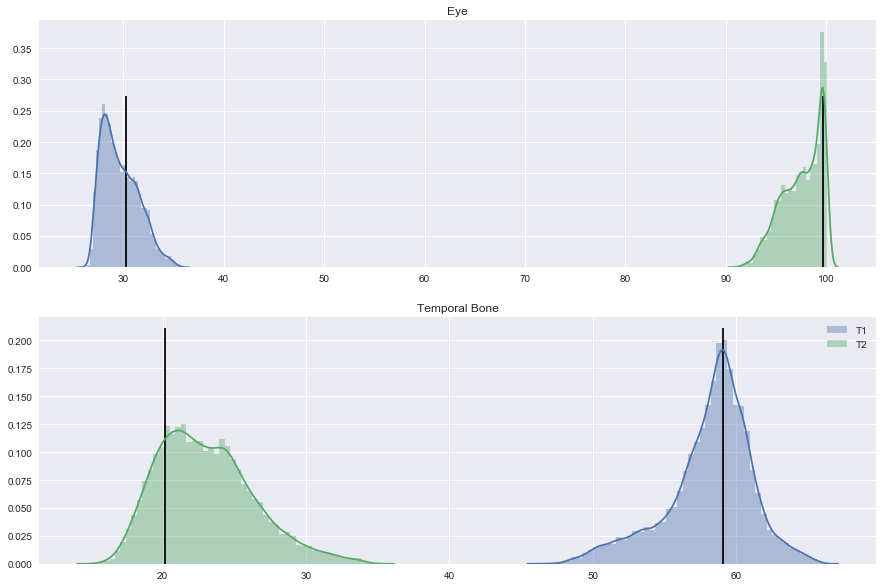

T1 eye: 30.2932719348
T2 eye: 99.6852655299
T1 temp: 59.1088402376
T2 temp: 20.1369810067


In [16]:
#Plot mask dists

def plot_mask_dist(t1, t2, eye_mask, temp_mask, stat = None):
    
    if stat == 'mean':
        t1_eye_stat = np.mean(t1[eye_mask])
        t1_temp_stat = np.mean(t1[temp_mask])
        t2_eye_stat = np.mean(t2[eye_mask])
        t2_temp_stat = np.mean(t2[temp_mask])
        
    elif stat == 'median':
        t1_eye_stat = np.median(t1[eye_mask])
        t1_temp_stat = np.median(t1[temp_mask])
        t2_eye_stat = np.median(t2[eye_mask])
        t2_temp_stat = np.median(t2[temp_mask])
        
        
    elif stat == 'mode' or stat == None:
        t1_eye_stat = stats.mode(t1[eye_mask])[0][0]
        t1_temp_stat = stats.mode(t1[temp_mask])[0][0]
        t2_eye_stat = stats.mode(t2[eye_mask])[0][0]
        t2_temp_stat = stats.mode(t2[temp_mask])[0][0]
        
    
    fig = plt.figure(figsize = [15, 10]);
    plt.subplot(2,1,1);
    plt.title('Eye')
    sns.distplot(t1[eye_mask], label = 'T1');
    ymax = fig.gca().axes.get_ybound()[1]
    plt.vlines(x = t1_eye_stat, ymin = 0, ymax = ymax)
    sns.distplot(t2[eye_mask], label = 'T2');
    plt.vlines(x = t2_eye_stat, ymin = 0, ymax = ymax)
    
    
    plt.subplot(2,1,2);
    plt.title('Temporal Bone')
    sns.distplot(t1[temp_mask], label = 'T1');
    ymax = fig.gca().axes.get_ybound()[1]
    plt.vlines(x = t1_temp_stat, ymin = 0, ymax = ymax)
    sns.distplot(t2[temp_mask], label = 'T2');
    plt.vlines(x = t2_temp_stat, ymin = 0, ymax = ymax)
    plt.legend()
    plt.show()
    
    print('T1 eye: {}\nT2 eye: {}\nT1 temp: {}\nT2 temp: {}'.format(t1_eye_stat, t2_eye_stat, t1_temp_stat, t2_temp_stat))

plot_mask_dist(t1_im_mni, t2_im_mni, eye_mni_mask, temp_mni_mask, 'mode')

In [21]:
#Warp MNI to subj space

output_filename = 'output_warped_image.nii.gz'

def ants_reg(fixed = None, moving = None, prefix = None, fixed_mask = None, moving_mask = None, out_image_filename = None):
    
    '''
    Uses ANTs to warp the moving image to the space of the fixed. 
    Both fixed and moving images can have masks.
    
    If warping subjects with lesion damage, it is recommended to warp from MNI to subj space 
    (fixed = subj, moving = mni template, fixed_mask = lesion mask) then
    use the inverse transform to warp from subj to MNI.
    
    '''
    reg = ants.Registration()
    reg.inputs.fixed_image = fixed
    reg.inputs.moving_image = moving

    if fixed_mask != None:
        reg.inputs.fixed_mask = fixed_mask

    if moving_mask != None:
        reg.inputs.moving_mask = fixed_mask

    if prefix != None:
        reg.inputs.output_transform_prefix = prefix
    else:
        reg.inputs.output_transform_prefix = 'out_trans_'
    reg.inputs.transforms = ['Rigid', 'Affine', 'SyN']
    reg.inputs.transform_parameters = [(0.1,),(0.1,),(0.1, 3.0, 0.0)] #Size of movement for registration (Optimal values are 0.1-0.25.)
    reg.inputs.number_of_iterations =[[1000, 500, 250, 100],[1000, 500, 250, 100],[100, 70, 50, 20]]
    reg.inputs.dimension = 3
    # '''
    # Align the moving_image and fixed_image before registration using the geometric
    # center of the images (=0), the image intensities (=1),or the origin of the images (=2)
    # '''
    reg.inputs.initial_moving_transform_com = 0 
    reg.inputs.write_composite_transform = True
    reg.inputs.collapse_output_transforms = False
    reg.inputs.initialize_transforms_per_stage = False
    reg.inputs.metric = ['MI', 'MI', 'CC']
    reg.inputs.radius_or_number_of_bins = [32, 32, 4]
    reg.inputs.sampling_strategy = ['Regular','Regular','None']
    reg.inputs.sampling_percentage = [0.25, 0.25, 1]
    reg.inputs.convergence_threshold = [1e-06]
    reg.inputs.convergence_window_size = [10]
    reg.inputs.smoothing_sigmas = [[3, 2, 1, 0]] * 3
    reg.inputs.sigma_units = ['vox'] * 3
    reg.inputs.shrink_factors = [[8, 4, 2, 1]] * 3
    reg.inputs.use_estimate_learning_rate_once = [True, True, True]
    reg.inputs.use_histogram_matching = True
    if output_filename == None:
        reg.inputs.output_warped_image = 'output_warped_image.nii.gz'
    else:
        reg.inputs.output_warped_image = output_filename + '.nii.gz'
    reg.inputs.num_threads = 8
    reg.inputs.metric_weight = [1.0] * 3
    reg.inputs.winsorize_lower_quantile = 0.005
    reg.inputs.winsorize_upper_quantile = 0.995
    reg.inputs.verbose = True
    res = reg.run()
        
output_filename = 'output_warped_image.nii.gz'
ants_reg(fixed = t1_im_subj_fn, moving = t1_im_mni_fn, output_filename = output_filename)

SyntaxError: invalid syntax (<ipython-input-21-96a154d044c9>, line 53)

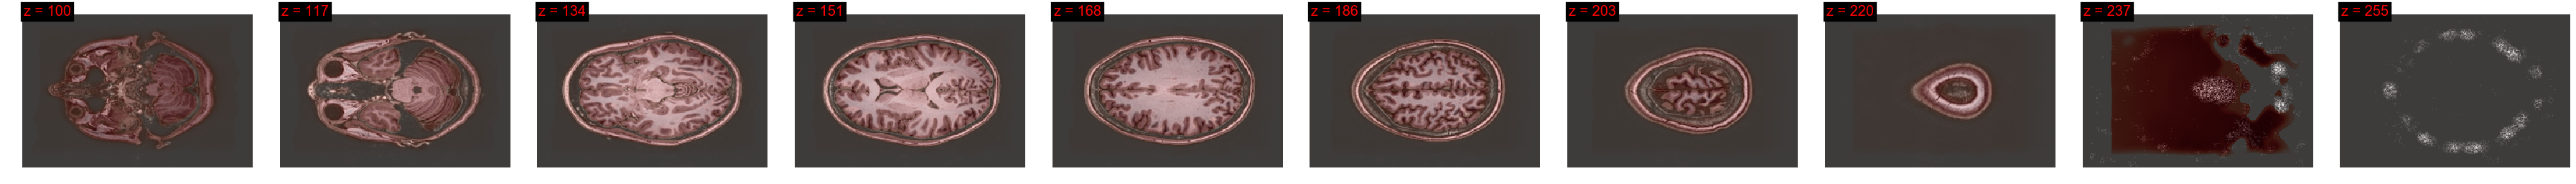

In [22]:
#Check warp quality

def plot_ants_warp(fixed, moving, nslices, output_name = None):
    """
    Plots nslices axial images of the fixed and moving images from the ants transform
    
    inputs:
    anat - Fixed image (image the moving was warped to) 
    moving - Moving image (Transformed image)
    nslices - Number of slices to plot
    output_name - filename to save png image to (optional)
    
    """
    fixed_data = nb.load(fixed).get_data()
    moving_data = nb.load(moving).get_data()
    
    view_slices = np.linspace(100, fixed_data.shape[1] - 1, num = nslices).astype(int)
    
    fig = plt.figure(figsize = [50, 25])

    for n, view_slice in enumerate(view_slices):
        plt.subplot(1, nslices, n + 1)
        plt.imshow(fixed_data[:, :, view_slice], cmap = 'Greys_r')
        plt.imshow(moving_data[:, :, view_slice], cmap = 'Reds', alpha = 0.25)
        plt.axis('off')
        plt.text(1,1, 'z = ' + str(view_slice), color = [1,0,0], bbox=dict(facecolor=[0,0,0]), fontsize = 20)
        plt.tight_layout()
    plt.show()
    
    if output_name != None:
        fig.savefig(fname = output_name + '.png')
        
plot_ants_warp(t1_im_subj_fn, output_filename, 10, 'warp')

In [25]:
#Transform eye + temporal mask + brain mask from MNI to subj

def mask_transform(mask_list, ref, transmat):
    '''
    Transforms masks from MNI to subj space
    masks = list of eye + temporal mask images
    transmat = mapping from MNI > subj space
    '''
    
    for mask in mask_list:
    
        image_name = mask.split('.')[0]
        print(image_name)
        
        mni2subj = ants.ApplyTransforms()
        mni2subj.inputs.input_image = mask
        mni2subj.inputs.reference_image = ref
        mni2subj.inputs.transforms = transmat
        mni2subj.inputs.interpolation = 'Linear'
        mni2subj.inputs.output_image = image_name + '_subj.nii.gz'
        mni2subj.run()

        
mask_list = [eye_mni_mask_fn, temp_mni_mask_fn, brain_mask_fn]        
        
mask_transform(mask_list, t1_im_subj_fn, 'out_trans_Composite.h5')

eye_mask
temp_bone_mask
mni_icbm152_mask


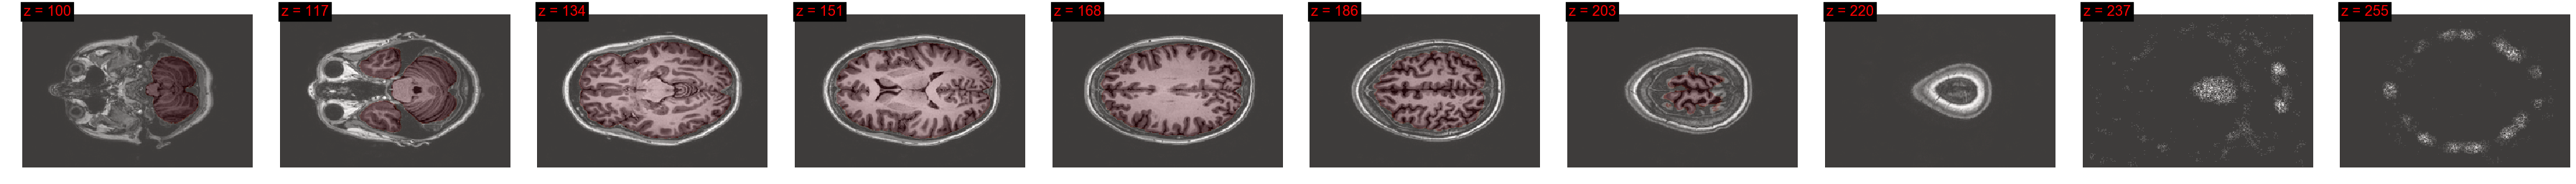

In [26]:
#Check brain extraction output
plot_ants_warp(t1_im_subj_fn, 'mni_icbm152_mask_subj.nii.gz', 10, 'brain_mask')

In [28]:
#Register T2 to T1

trans_prefix = 'rigid_trans_'

reg = ants.Registration()

reg.inputs.fixed_image = t1_im_subj_fn
reg.inputs.moving_image = t2_im_subj_fn
reg.inputs.output_transform_prefix = trans_prefix
reg.inputs.transforms = ['Rigid']
reg.inputs.transform_parameters = [(0.1,)] #Size of movement for registration (Optimal values are 0.1-0.25.)
reg.inputs.number_of_iterations = [[1000, 500, 250, 100]]
reg.inputs.dimension = 3
# '''
# Align the moving_image and fixed_image before registration using the geometric
# center of the images (=0), the image intensities (=1),or the origin of the images (=2)
# '''
reg.inputs.initial_moving_transform_com = 0 
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.initialize_transforms_per_stage = False
reg.inputs.metric = ['MI']
reg.inputs.radius_or_number_of_bins = [32]
reg.inputs.sampling_strategy = ['Regular']
reg.inputs.sampling_percentage = [0.25]
reg.inputs.convergence_threshold = [1e-06]
reg.inputs.convergence_window_size = [10]
reg.inputs.smoothing_sigmas = [[3, 2, 1, 0]]
reg.inputs.sigma_units = ['vox']
reg.inputs.shrink_factors = [[8, 4, 2, 1]]
reg.inputs.use_estimate_learning_rate_once = [True]
reg.inputs.use_histogram_matching = [True]
reg.inputs.output_warped_image = trans_prefix + 't2_image.nii.gz'
reg.inputs.num_threads = 8
reg.inputs.metric_weight = [1.0]
reg.inputs.winsorize_lower_quantile = 0.005
reg.inputs.winsorize_upper_quantile = 0.995
reg.inputs.verbose = True
res = reg.run()

180419-18:44:46,221 interface INFO:
	 stdout 2018-04-19T18:44:46.221538:All_Command_lines_OK
180419-18:44:46,223 interface INFO:
	 stdout 2018-04-19T18:44:46.221538:Using double precision for computations.
180419-18:44:47,262 interface INFO:
	 stdout 2018-04-19T18:44:47.262103:=============================================================================
180419-18:44:47,262 interface INFO:
	 stdout 2018-04-19T18:44:47.262103:The composite transform comprises the following transforms (in order): 
180419-18:44:47,263 interface INFO:
	 stdout 2018-04-19T18:44:47.262103:  1. Image center alignment using fixed image: KKI2009-30-MPRAGE.nii and moving image: KKI2009-30-T2w.nii (type = Euler3DTransform)
180419-18:44:47,264 interface INFO:
	 stdout 2018-04-19T18:44:47.262103:=============================================================================
180419-18:44:47,268 interface INFO:
	 stdout 2018-04-19T18:44:47.268415:  number of levels = 4
180419-18:44:47,269 interface INFO:
	 stdout 2018-0

180419-18:44:47,539 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:  Object Name: 
180419-18:44:47,539 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:  Observers: 
180419-18:44:47,540 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:    none
180419-18:44:47,541 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:  Source: (none)
180419-18:44:47,542 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:  Source output name: (none)
180419-18:44:47,542 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:  Release Data: Off
180419-18:44:47,543 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:  Data Released: False
180419-18:44:47,544 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:  Global Release Data: Off
180419-18:44:47,544 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:  PipelineMTime: 0
180419-18:44:47,545 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:  UpdateMTime: 1588
180419-18:44:47,546 interface INFO:
	 stdout 2018-04-19T18:44:47.526665:  RealTimeStam

180419-18:44:48,429 interface INFO:
	 stdout 2018-04-19T18:44:48.423187:  regular sampling (percentage = 0.25)
180419-18:44:48,430 interface INFO:
	 stdout 2018-04-19T18:44:48.430692:
180419-18:44:48,432 interface INFO:
	 stdout 2018-04-19T18:44:48.430692:*** Running Euler3DTransform registration ***
180419-18:44:48,434 interface INFO:
	 stdout 2018-04-19T18:44:48.430692:
180419-18:44:50,225 interface INFO:
	 stdout 2018-04-19T18:44:50.224927:DIAGNOSTIC,Iteration,metricValue,convergenceValue,ITERATION_TIME_INDEX,SINCE_LAST
180419-18:44:50,228 interface INFO:
	 stdout 2018-04-19T18:44:50.224927: 2DIAGNOSTIC,     1, -5.378376454478e-01, 1.797693134862e+308, 1.8026e+00, 1.8026e+00, 
180419-18:44:50,239 interface INFO:
	 stdout 2018-04-19T18:44:50.239432: 2DIAGNOSTIC,     2, -5.387865668843e-01, 1.797693134862e+308, 1.8171e+00, 1.4490e-02, 
180419-18:44:50,259 interface INFO:
	 stdout 2018-04-19T18:44:50.259360: 2DIAGNOSTIC,     3, -5.396709795895e-01, 1.797693134862e+308, 1.8370e+00, 1.98

180419-18:45:00,447 interface INFO:
	 stdout 2018-04-19T18:45:00.447268: 2DIAGNOSTIC,    16, -4.335491940521e-01, 2.369422694229e-06, 1.2024e+01, 1.1616e+00, 
180419-18:45:00,835 interface INFO:
	 stdout 2018-04-19T18:45:00.835423: 2DIAGNOSTIC,    17, -4.335491940521e-01, 1.543535649400e-06, 1.2412e+01, 3.8810e-01, 
180419-18:45:01,132 interface INFO:
	 stdout 2018-04-19T18:45:01.132449: 2DIAGNOSTIC,    18, -4.335491940521e-01, 1.591679231132e-06, 1.2709e+01, 2.9702e-01, 
180419-18:45:01,478 interface INFO:
	 stdout 2018-04-19T18:45:01.477915: 2DIAGNOSTIC,    19, -4.335491940521e-01, 2.263250967596e-06, 1.3054e+01, 3.4543e-01, 
180419-18:45:01,786 interface INFO:
	 stdout 2018-04-19T18:45:01.786344: 2DIAGNOSTIC,    20, -4.335491940521e-01, 2.409984610749e-06, 1.3363e+01, 3.0844e-01, 
180419-18:45:02,107 interface INFO:
	 stdout 2018-04-19T18:45:02.107845: 2DIAGNOSTIC,    21, -4.335491940521e-01, 2.107634189855e-06, 1.3684e+01, 3.2147e-01, 
180419-18:45:02,441 interface INFO:
	 stdout 2

In [32]:
def bias_corr(images, mask):
    '''
    Uses N4 bias correction to remove intensity inhomogeneities
    
    Input:
    images = List of images (w/ paths) to be corrected
    '''
    for n, image in enumerate(images):
        image_name = image.split('.')[0]
        print(image_name)
        
        n4  = ants.N4BiasFieldCorrection()
        n4.inputs.dimension = 3
        n4.inputs.mask_image = mask
        n4.inputs.input_image = image
        n4.inputs.bspline_fitting_distance = 300
        n4.inputs.shrink_factor = 3
        n4.inputs.n_iterations = [50,50,30,20]
        n4.inputs.save_bias = True
        n4.inputs.bias_image = image_name + '_bias_field.nii.gz'
        n4.inputs.output_image = image_name + '_bias_corr.nii.gz'
        n4.run()
        
bias_corr([t1_im_subj_fn, trans_prefix + 't2_image.nii.gz'], 'mni_icbm152_mask_subj.nii.gz')

KKI2009-30-MPRAGE
rigid_trans_t2_image


<img src='formula.png'>

Simplified Y = m*x + b

XR = Temporal bone MNI

YR = Eyes MNI

XS = Temporal bone subj

YR = Eyes subj

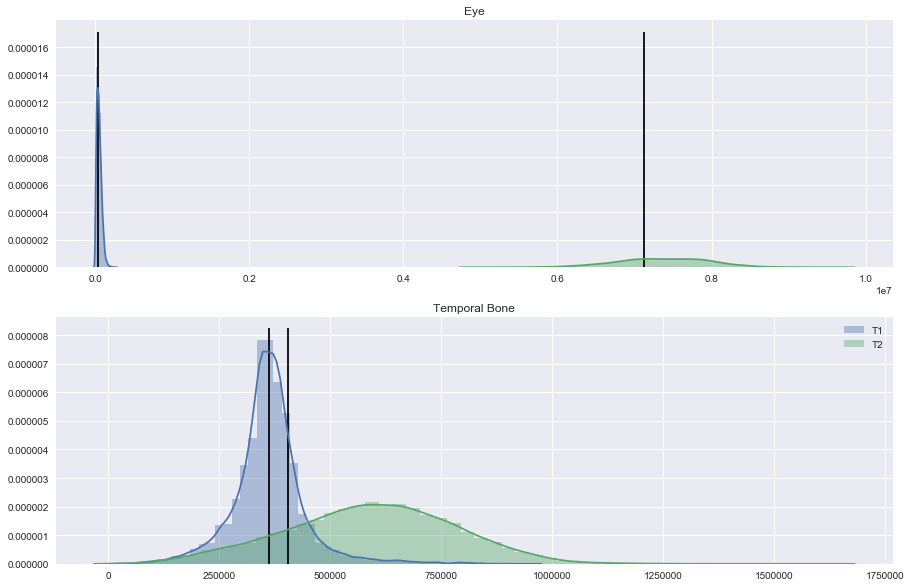

T1 eye: 33126.84375
T2 eye: 7126830.5
T1 temp: 361082.59375
T2 temp: 405617.0


In [33]:
#Calibration stage
t1_bias_corr = nb.load('KKI2009-30-MPRAGE_bias_corr.nii.gz').get_data()
t2_bias_corr = nb.load('rigid_reg_image_bias_corr.nii.gz').get_data()

eye_subj_mask = nb.load('eye_mask_subj.nii.gz').get_data().astype(bool)
temp_subj_mask = nb.load('temp_bone_mask_subj.nii.gz').get_data().astype(bool)

t1_subj_eye = stats.mode(t1_bias_corr[eye_subj_mask])[0][0]
t1_subj_temp = stats.mode(t1_bias_corr[temp_subj_mask])[0][0]
t2_subj_eye = stats.mode(t2_bias_corr[eye_subj_mask])[0][0]
t2_subj_temp = stats.mode(t2_bias_corr[temp_subj_mask])[0][0]

plot_mask_dist(t1_bias_corr, t2_bias_corr, eye_subj_mask, temp_subj_mask, 'mode')

In [34]:
brain_mask = nb.load('mni_icbm152_mask_subj.nii.gz').get_data().astype(bool)

In [35]:
t1_bias_corr[brain_mask].shape

(1085837,)

In [36]:
t1_a = (t1_mni_temp - t1_mni_eye) / (t1_subj_temp - t1_subj_eye)
t1_b = ((t1_subj_temp * t1_mni_eye) - (t1_mni_temp * t1_subj_eye)) / (t1_subj_temp - t1_subj_eye)

t2_a = (t2_mni_temp - t2_mni_eye) / (t2_subj_temp - t2_subj_eye)
t2_b = ((t2_subj_temp * t2_mni_eye) - (t2_mni_temp * t2_subj_eye)) / (t2_subj_temp - t2_subj_eye)

In [37]:
#Intensity correction
t1_corr = (t1_a * t1_bias_corr[brain_mask]) + t1_b
t2_corr = (t2_a * t2_bias_corr[brain_mask]) + t2_b

print(np.percentile(t1_corr, [0,100]))
print(np.percentile(t2_corr, [0,100]))
print(np.percentile(t1_bias_corr, [0, 100]))
print(np.percentile(t2_bias_corr, [0, 100]))

[  27.38260841  154.28753662]
[  15.72074223  142.88497925]
[       0.   2408321.5]
[        0.  10776871.]


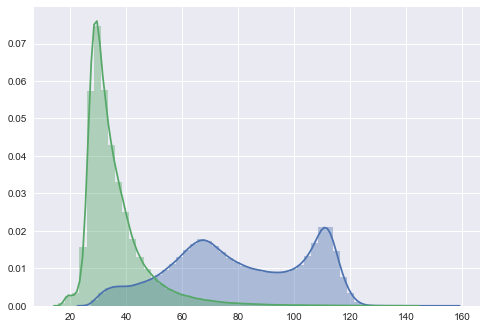

In [38]:
sns.distplot(t1_corr)
sns.distplot(t2_corr)

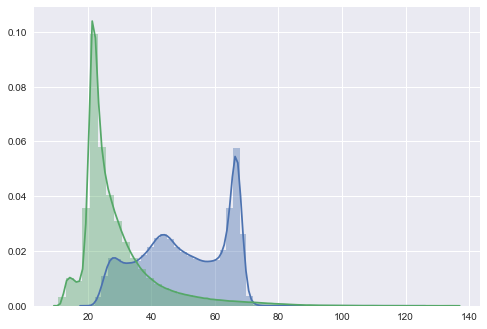

In [39]:
mask = nb.load('/mnt/data/kirby30/gs/tmp/mrt1w_mask.nii').get_data().astype(bool)
t1 = nb.load('/mnt/data/kirby30/gs/tmp/ewmt1w.nii').get_data()
t2 = nb.load('/mnt/data/kirby30/gs/tmp/ewmt2w.nii').get_data()
t1t2 = nb.load('/mnt/data/kirby30/gs/tmp/ewmt1w_on_t2w_masked.nii').get_data()

sns.distplot(t1[mask])
sns.distplot(t2[mask])

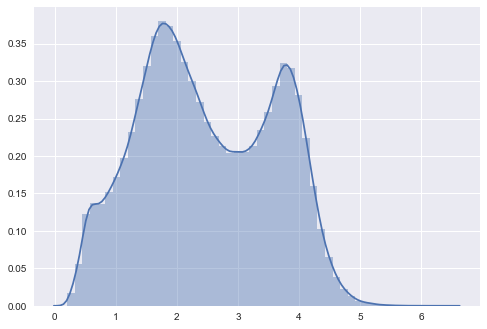

In [40]:
mm_arr = t1_corr / t2_corr
sns.distplot(mm_arr)

# im_min_thresh, im_max_thresh = np.percentile(mm_arr, [0.01, 99.99])
# print(im_min_thresh, im_max_thresh)

In [42]:
mm = np.zeros(brain_mask.shape, dtype = type(t1_bias_corr))
mm[brain_mask] = mm_arr
mm.shape

(170, 256, 256)

In [44]:
fn = 't1t2.nii.gz'

nb.Nifti1Image(mm, affine = t1_hdr_subj.affine, header = t1_hdr_subj.header).to_filename(fn)

In [45]:
#Warp to MNI space

moving = 't1t2.nii.gz'
ref = t1_im_mni_fn
transmat = 'out_trans_InverseComposite.h5'

subj2mni = ants.ApplyTransforms()
subj2mni.inputs.dimension = 3
subj2mni.inputs.input_image = moving
subj2mni.inputs.reference_image = ref
subj2mni.inputs.transforms = transmat
subj2mni.inputs.output_image = 't1t2_mni.nii.gz'
subj2mni.run()